In [2]:
import Pkg
Pkg.activate("../../Tasks2D")
using Revise, Plots

  Activating project at `~/Developer/tasks2D/Tasks2D`


In [3]:
import LineWorlds
const L = LineWorlds
const Geo = L.Geometry

import GridWorlds
const GW = GridWorlds

using Gen
import GenPOMDPs

In [357]:
### Construct Environment ###
include("12/model.jl") # Loads variables: uniform_agent_pos, motion_model, sensor_model

# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, actions, params ⇝ state
    sensor_model,            # OBS    : state, params               ⇝ observation
    (state, action) -> -1.   # UTILITY: state, action, params       → utility
)

GenPOMDPs.GenPOMDP(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##uniform_agent_pos#11864", Bool[0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##motion_model#11865", Bool[0, 0, 0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##sensor_model#11866", Bool[0, 0], false), var"#600#601"())

In [323]:
# Particle filter for the model above.
includet("09/pf.jl")          # Loads: @get_pf

# A* navigation, using conversion to discrete coordinates.
includet("09/astar_nav.jl")   # Loads: line_to_grid, taxi_dist, find_action_using_grid_search

# Wall following behavior.
includet("09/wall_follow.jl") # Loads: initial_wall_follow_state, wall_follow

# Rule for whether a belief state is sufficiently uncertain to be worth disambiguating.
includet("09/uncertainty_thresholding.jl") # Loads: there_is_ambiguity

In [6]:
# Visualizations.
includet("12/visualize.jl") # Loads: trace_to_gif, trace_to_path_image

In [7]:
includet("12/hotel_env.jl")

In [8]:
# (_segs, _bb, _) = L.load_env_sparse("../../data/environments/ambig.json");
(_segs, _bb) = construct_hotel_env(4); # 5 room hotel environment

In [9]:
# Parameters for the grid discretization used for planning
ϵ = 0.25
(grid, edges, l_to_g, g_to_l) = line_to_grid(_segs, _bb, ϵ)
w = GridWorlds.boolmatrix_to_grid(grid, (length(edges[1]), length(edges[2])));

In [10]:
GOAL = [1., 7.]

2-element Vector{Float64}:
 1.0
 7.0

In [11]:
function goal_object_segs(goal, sidelength=1.)
    (x, y) = goal
    δ = sidelength/2
    return [ # square
        L.Segment([x - δ, y - δ, x + δ, y - δ]),
        L.Segment([x + δ, y - δ, x + δ, y + δ]),
        L.Segment([x + δ, y + δ, x - δ, y + δ]),
        L.Segment([x - δ, y + δ, x - δ, y - δ])
    ]
end

goal_object_segs (generic function with 2 methods)

In [12]:
goalobj = goal_object_segs(GOAL);

In [358]:
### Ground truth world model parameters ###
PARAMS = (;
    map = vcat(_segs, goalobj), # The map consists of the walls, and the goal object
    orientation = π/2,
    p_kidnapped = 1e-6,
    bounding_box = L.bounding_box(_segs),
    step = (; Δ = 0.25, σ = 0.005 ),
    obs = (; fov = 2π, n_rays = 80,
        sensor_args = (;
            w = 5, s_noise = 0.02,
            outlier = 0.0001, outlier_vol = 100.0,
            zmax = 100.0
)));

In [359]:
avg(x, y) = (x+y)/2
center = [avg(_bb[1][1], _bb[2][1]), avg(_bb[1][2], _bb[2][2])]
Δy = _bb[2][2] - _bb[1][2]
Δx = _bb[2][1] - _bb[1][1]
y_to_x = Δy/Δx
step = sqrt(Δx^2 * y_to_x / 400)
@assert Δy/step * Δx/step ≈ 400
nstepsy = Int(floor(Δy/step))
nstepsx = Int(floor(Δx/step));

In [360]:
### Particle Filter args ###
_grid_args = (;
    tau = 1., pmin = 1e-6, n_iters = 3,
    init_grid_args = (; k = [9, 9], r = [PARAMS.step.Δ/6, PARAMS.step.Δ/6]),
)
_t0_grid_args = (;
    _grid_args..., tau=1., n_iters=6,
    init_grid_args = (; k=[nstepsx, nstepsy], r = [step, step]), initial_pos = center
)

INFERENCE_PARAMS = (;
    PARAMS...,
    step = (; Δ = 0.25, σ = 0.1),
    p_kidnapped=0.,
    obs = (; PARAMS.obs..., sensor_args=(;
        PARAMS.obs.sensor_args...,
        s_noise = 0.1,
    ))
)

# 1 particle!
_resampling_args = (; n_particles=1, n_groups=1, ess_threshold=0.)

### Particle filter ###
pf = @get_pf(INFERENCE_PARAMS, _grid_args, _t0_grid_args, _resampling_args);
(pf_init, pf_update) = pf;

In [361]:
### Calibrate lm estimate threshold ###

# Step 1: collect a bunch of samples of p(obs | state) for random states generated from the initial timestep model
logpy_values = []
for _=1:1000
    state = uniform_agent_pos(INFERENCE_PARAMS)
    obs_tr = simulate(sensor_model, (state, INFERENCE_PARAMS))
    push!(logpy_values, get_score(obs_tr))
end

delta = maximum(logpy_values) - minimum(logpy_values)

# Heuristic.  [TODO -- think more about principled ways of setting such thresholds.]
logpy_threshold = minimum(logpy_values) #- max(delta, 10)

is_shockingly_low(log_py_estimate) = log_py_estimate < logpy_threshold

is_shockingly_low (generic function with 1 method)

In [362]:
initial_controller_state = (nothing, nothing) # pf state, prev action, previous lml estimate for trace

@gen function controller(st, obs)
    # Unpack controller state
    pf_state, prev_action = st
    
    # Create 1-particle belief state
    if isnothing(prev_action) # First timestep
        pf_state = pf_init(choicemap((:obs, obs)))
    else
        prev_lml_est = GenParticleFilters.get_lml_est(pf_state)
        pf_state = pf_update(pf_state, prev_action, choicemap((:obs, obs)))
        new_lml_est = GenParticleFilters.get_lml_est(pf_state)
        if is_shockingly_low(new_lml_est - prev_lml_est)
            # Reset the particle filter!
            pf_state = pf_init(choicemap((:obs, obs)))
        end
    end

    # Choose action
    action = find_action_using_grid_search(currentpos(pf_state.traces[1]), GOAL)[1]

    # Occasionally, mismatch between the grid map and the continuous map will cause the
    # A* controller to push the agent into a wall.
    # To fix it, we just notice if it looks like the agent is running into a wall;
    # if so, we take a step orthogonal to the wall.
    pf_T = T(pf_state.traces[1])
    if pf_T > 0
        prev_pos = pf_state.traces[1][GenPOMDPs.state_addr(pf_T - 1)]
        pos = pf_state.traces[1][GenPOMDPs.state_addr(pf_T)]
        if taxi_dist(pos, prev_pos) < ϵ/10 && action == prev_action
            if prev_action in (:left, :right)
                action = rand() < .5 ? :up : :down
            else
                action = rand() < .5 ? :left : :right
            end
        end
    end
    
    # Return action and new controller state
    return (action, (pf_state, action))
end

controller = GenPOMDPs.Controller(controller, initial_controller_state)

GenPOMDPs.Controller(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##controller#11932", Bool[0, 0], false), (nothing, nothing))

In [363]:
rollout_model = GenPOMDPs.RolloutModel(pomdp, controller)

GenPOMDPs.var"##StaticGenFunction__RolloutModel#12001"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

Plots.AnimatedGif("/tmp/jl_1IfERGpo58.gif")
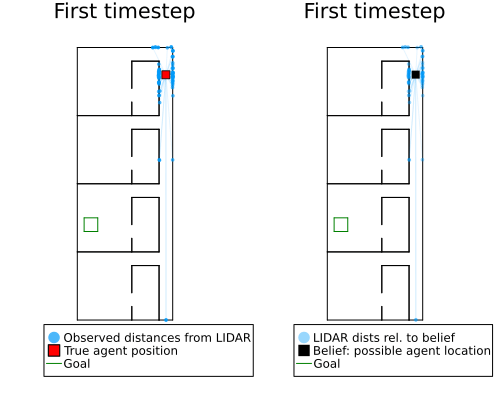

In [330]:
INITIAL_POS = [6.5, 4*5 - 2]

# Simulate rollout to the end of T=0 (ie. generate initial state + obs, and an initial action)
rollout_tr = Gen.generate(rollout_model, (0, PARAMS), 
    choicemap((GenPOMDPs.state_addr(0, :pos), INITIAL_POS))
)[1]

trace_to_gif(rollout_tr; goalobj=goalobj, title="First timestep")

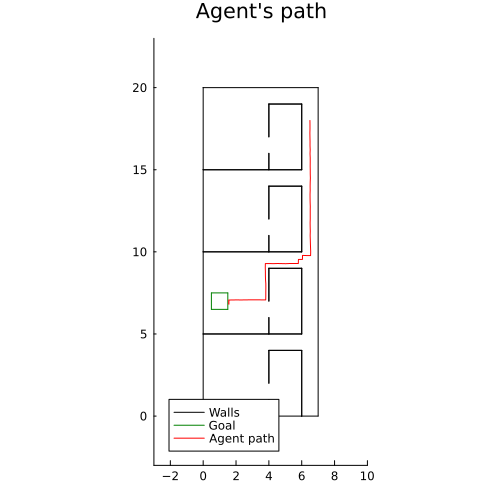

In [331]:
# Extend rollout to 40 steps...
rollout_tr, _ = @time Gen.update(rollout_tr, (80, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap());

trace_to_path_image(rollout_tr; goalobj=goalobj)

Plots.AnimatedGif("/tmp/jl_L8xSBA7CX6.gif")
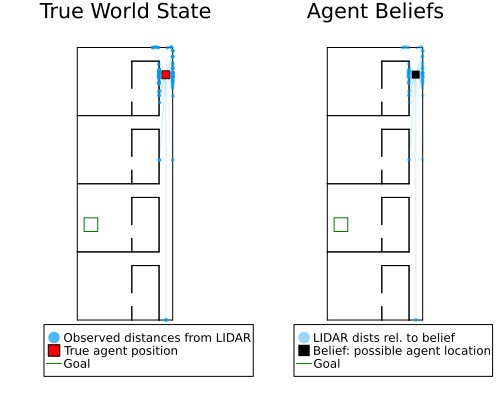

In [332]:
trace_to_gif(rollout_tr; goalobj=goalobj, fps=10)

In [33]:
# lml_ests = [GenParticleFilters.get_lml_est(pfst)
# for (pfst, _) in GenPOMDPs.controllerstate_sequence(rollout_tr)]
# deltas = [x - y for (x, y) in zip(lml_ests[2:end], lml_ests[1:end-1])]
# # scatter(LinRange(1, 38, 1000), logpy_values, c=:gray)
# plt = plot()
# # scatter!(1:38, deltas)
# # plot!(1:38, deltas)
# plot!(1:38, [logpy_threshold for _ in 1:38])

In [441]:
### Weaker baseline -- relocate from scratch at each step. ###

# pf2 = @get_pf(INFERENCE_PARAMS, _grid_args,
#     (;
#         _grid_args..., tau=3., n_iters=6,
#         init_grid_args = (; k=[nstepsx, nstepsy], r = [step, step]), initial_pos = center
#     ), (; n_particles=20, n_groups=1, ess_threshold=0.));
# (pf_init2, _) = pf2;
pf_init2=pf_init;
_gettr(st) = GenParticleFilters.sample_unweighted_traces(st, 1)[1]
@gen function _baseline1_controller(st, obs)
    pf_state = pf_init2(choicemap((:obs, obs)))
    action = find_action_using_grid_search(currentpos(pf_state.traces[1]), GOAL)[1]

    if !isempty(st[2])
        prev_pos = _gettr(st[1])[GenPOMDPs.state_addr(0)]
        pos = _gettr(pf_state)[GenPOMDPs.state_addr(0)]
        prev_action = st[3]

        old_pf_states = st[2]
        x = min(10, length(old_pf_states)-1)
        n_overlaps = length(findall(
            [taxi_dist(pos, _gettr(pfst)[GenPOMDPs.state_addr(0)]) < ϵ/2 for pfst in old_pf_states[end-x:end]]
        ))

        if n_overlaps>1
            if prev_action in (:left, :right)
                action = rand() < .5 ? :up : :down
            else
                action = rand() < .5 ? :left : :right
            end
        end
    end

    # if rand() < .05
    #     action = [:up, :down, :left, :right][categorical([.25, .25, .25, .25])]
    # end

    return (action, (pf_state, vcat(st[2], [pf_state]), action))
end

baseline1_controller = GenPOMDPs.Controller(_baseline1_controller, (nothing, [], nothing))

GenPOMDPs.Controller(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##_baseline1_controller#15808", Bool[0, 0], false), (nothing, Any[], nothing))

In [437]:
baseline_rollout_model = GenPOMDPs.RolloutModel(pomdp, baseline1_controller)

GenPOMDPs.var"##StaticGenFunction__RolloutModel#15367"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

Plots.AnimatedGif("/tmp/jl_vA9WXeT2L4.gif")
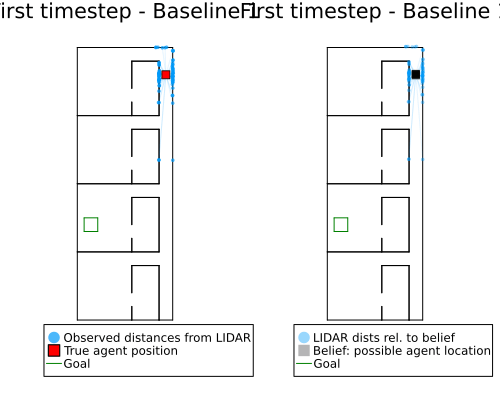

In [438]:
baseline_rollout_tr = Gen.generate(baseline_rollout_model, (0, PARAMS), 
    choicemap((GenPOMDPs.state_addr(0, :pos), INITIAL_POS))
)[1]

trace_to_gif(baseline_rollout_tr; goalobj=goalobj, title="First timestep - Baseline 1")

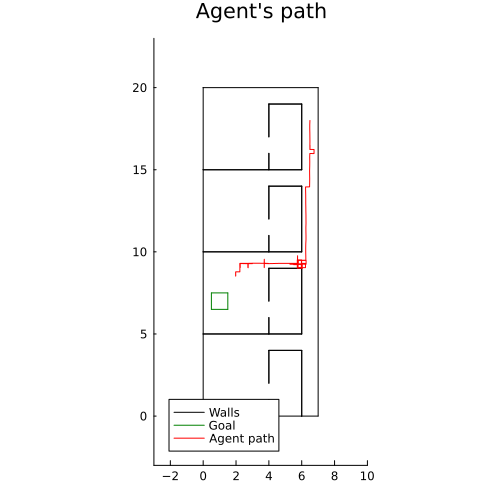

In [439]:
# Extend rollout...
baseline_rollout_tr, _ = @time Gen.update(baseline_rollout_tr, (200, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap())

trace_to_path_image(baseline_rollout_tr; goalobj=goalobj)

Plots.AnimatedGif("/tmp/jl_1cLs3W5SDW.gif")
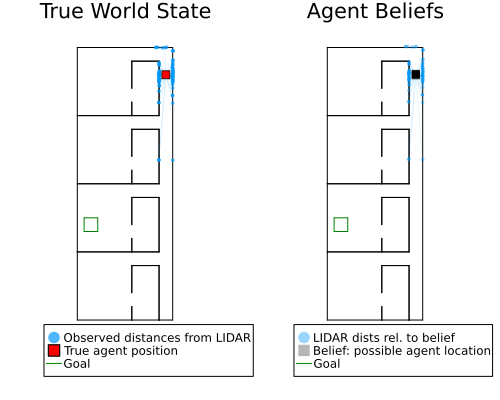

In [440]:
trace_to_gif(baseline_rollout_tr; goalobj=goalobj, fps=10)

In [340]:
function near_goal(tr)
    return taxi_dist(GOAL, tr[GenPOMDPs.state_addr(get_args(tr)[1])]) < 1.
end
function T_near_goal(tr)
    T = get_args(tr)[1]
    while T > 0
        T -= 1
        if taxi_dist(GOAL, tr[GenPOMDPs.state_addr(T)]) > 1.
            return T + 1
        end
    end
    return 500
end
function take_measurement(model)
    tr = Gen.generate(model, (0, PARAMS), 
        choicemap((GenPOMDPs.state_addr(0, :pos), INITIAL_POS))
    )[1]
    
    elapsed = 0
    T = 0
    while  T < 500
        T += 10
        t1 = time()
        tr = Gen.update(tr, (T, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap())[1]
        t2 = time()

        if near_goal(tr)
            wasted_steps = T - T_near_goal(tr)
            elapsed += (t2 - t1) * (10 - wasted_steps)/10
            break
        else
            elapsed += (t2 - t1)
        end
    end
    return (T_near_goal(tr), elapsed/T_near_goal(tr))
end

take_measurement (generic function with 1 method)

In [341]:
model_costs_runtimes = [take_measurement(rollout_model) for _=1:10];

In [342]:
baseline_costs_runtimes = [take_measurement(baseline_rollout_model) for _=1:10];

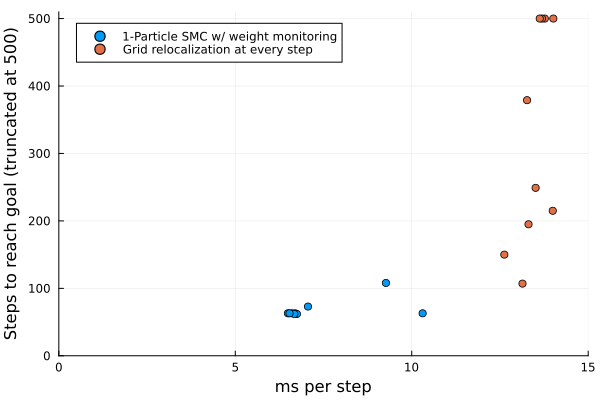

In [343]:
plot(;
    ylabel="Steps to reach goal (truncated at 500)",
    xlabel="ms per step",
    ylims=(0, 510),
    xlims=(0,15)
)
scatter!(map(x->x[2]*1000, model_costs_runtimes), map(x->x[1], model_costs_runtimes), label="1-Particle SMC w/ weight monitoring")
scatter!(map(x->x[2]*1000, baseline_costs_runtimes), map(x->x[1], baseline_costs_runtimes), label="Grid relocalization at every step")

## Kidnapped Robot Demo

Plots.AnimatedGif("/tmp/jl_DYbgnWByVo.gif")
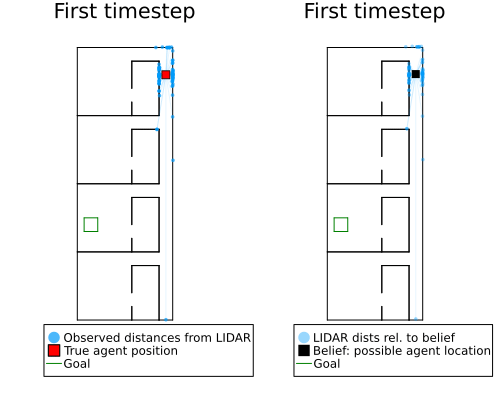

In [405]:
rollout_tr_KR = Gen.generate(rollout_model, (0, PARAMS), 
    choicemap((GenPOMDPs.state_addr(0, :pos), INITIAL_POS))
)[1]

trace_to_gif(rollout_tr_KR; goalobj=goalobj, title="First timestep")

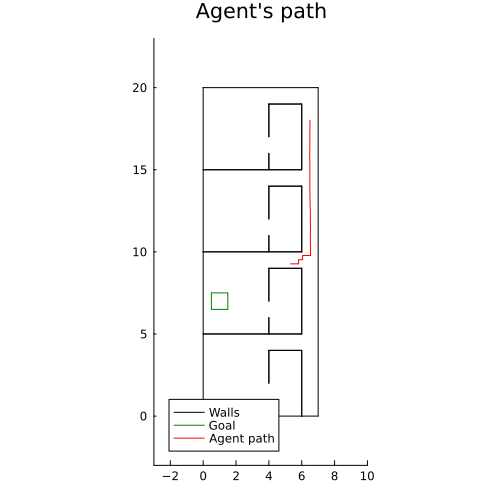

In [406]:
# Extend rollout to 40 steps...
rollout_tr_KR, _ = Gen.update(rollout_tr_KR, (40, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap());

trace_to_path_image(rollout_tr_KR; goalobj=goalobj)

In [407]:
## Kidnap the robot!
rollout_tr_KR, _ = Gen.update(rollout_tr_KR, (41, PARAMS), (UnknownChange(), NoChange()),
    choicemap((GenPOMDPs.state_addr(41, :is_kidnapped), true), (GenPOMDPs.state_addr(41, :pos), [5., 16.]))
);

# display the last few states:
GenPOMDPs.state_sequence(rollout_tr_KR)[end-3:end]

4-element Vector{Vector{Float64}}:
 [5.807761018950306, 9.270677015405376]
 [5.5636101890800935, 9.271786356366524]
 [5.315450289554744, 9.267756062230532]
 [5.0, 16.0]

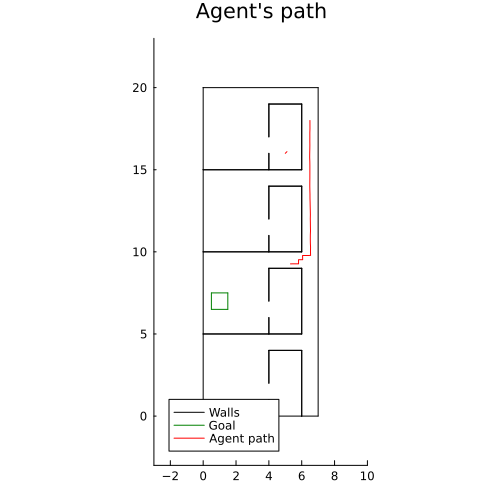

In [408]:
trace_to_path_image(rollout_tr_KR; goalobj=goalobj, kidnapped_at=[41])

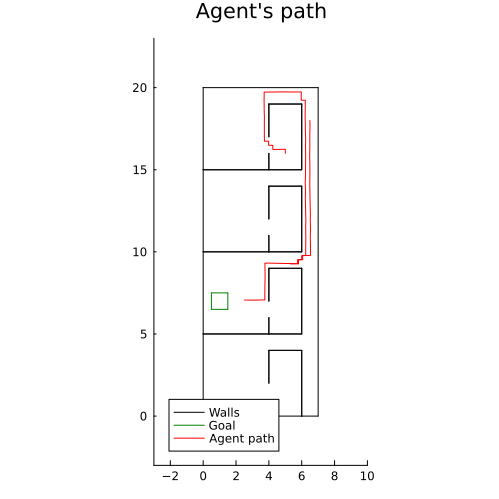

In [409]:
# Roll out the trace another 60 steps
rollout_tr_KR, _ = Gen.update(rollout_tr_KR, (140, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap());
trace_to_path_image(rollout_tr_KR; goalobj=goalobj, kidnapped_at=[41])

Plots.AnimatedGif("/home/ubuntu/Developer/tasks2D/notebooks_messy/lineworld_tasks/kidnapped_robot_demo_v1.gif")
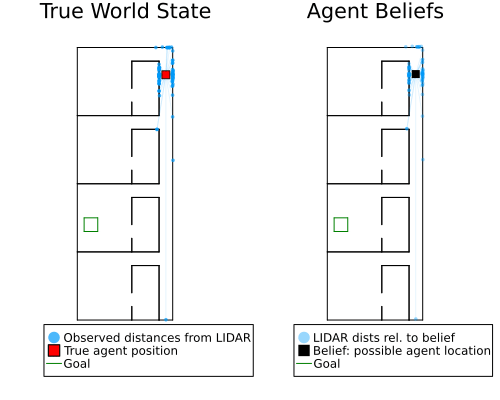

In [411]:
trace_to_gif(rollout_tr_KR; goalobj=goalobj, fps=10,
    kidnapped_at=[41],
    saveas="kidnapped_robot_demo_v1"
)

In [416]:
function take_measurement_KR(model)
    tr = Gen.generate(model, (0, PARAMS), 
        choicemap((GenPOMDPs.state_addr(0, :pos), INITIAL_POS))
    )[1]
    
    elapsed = 0
    t1 = time()
    tr = Gen.update(tr, (40, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap())[1]
    t2 = time()

    elapsed += t2 - t1

    tr, _ = Gen.update(tr, (41, PARAMS), (UnknownChange(), NoChange()),
        choicemap((GenPOMDPs.state_addr(41, :is_kidnapped), true), (GenPOMDPs.state_addr(41, :pos), [5., 16.]))
    );

    T = 41

    while  T < 501
        T += 10
        t1 = time()
        tr = Gen.update(tr, (T, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap())[1]
        t2 = time()

        if near_goal(tr)
            wasted_steps = T - T_near_goal(tr)
            elapsed += (t2 - t1) * (10 - wasted_steps)/10
            break
        else
            elapsed += (t2 - t1)
        end
    end
    return (T_near_goal(tr), elapsed/T_near_goal(tr))
end

take_measurement_KR (generic function with 1 method)

In [417]:
kr_measurements_demo = [take_measurement_KR(rollout_model) for _=1:10];

In [426]:
kr_measurements_b1 = [take_measurement_KR(baseline_rollout_model) for _=1:10];

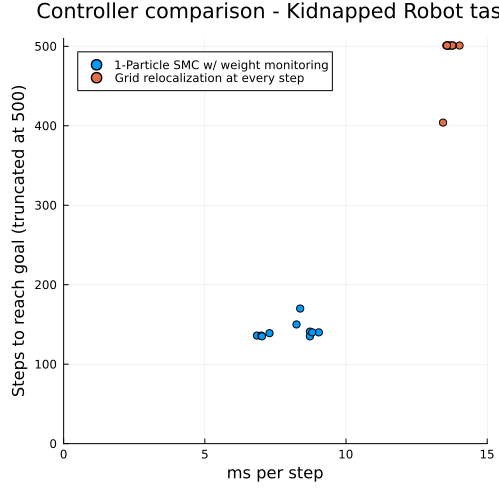

In [427]:
plot(;
    size=(500, 500),
    title="Controller comparison - Kidnapped Robot task",
    ylabel="Steps to reach goal (truncated at 500)",
    xlabel="ms per step",
    ylims=(0, 510),
    xlims=(0,15)
)
scatter!(map(x->x[2]*1000, kr_measurements_demo), map(x->x[1], kr_measurements_demo), label="1-Particle SMC w/ weight monitoring")
scatter!(map(x->x[2]*1000, kr_measurements_b1), map(x->x[1], kr_measurements_b1), label="Grid relocalization at every step")